# Develop an approach to image warping

In [129]:
from imagery_psychophysics.utils.variational_utils import *
from object_parsing.src.image_objects import object_box, mask_quantize
from skimage.transform import AffineTransform, matrix_transform, resize, SimilarityTransform
from scipy.interpolate import griddata
from scipy.ndimage import center_of_mass
from matplotlib import pyplot as plt
from copy import copy, deepcopy
from PIL.Image import fromarray
from scipy.linalg import expm
from scipy.stats import norm
from sklearn.metrics.pairwise import pairwise_distances
from theano import tensor as T
from theano import function, scan
from theano.tensor.extra_ops import squeeze as tsqueeze
import time

In [2]:
windows, resp, _, targetObjectMap,targetImage = open_imagery_probe_data('KL', 'pcp', 'peaches_05')

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [356]:
D1,D2 = (64,64)
smallMap = targetObjectMap.resize((D1,D2))
smallImage = resize(np.array(targetImage),(D1,D2),order=1,preserve_range=True)


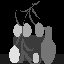

In [357]:
smallMap

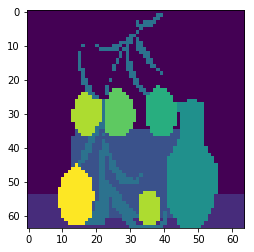

In [382]:

plt.imshow(np.digitize(np.array(smallMap),np.unique(smallMap).tolist()))

In [358]:
#select an object from the object map and create a box around it
print 'choose from these labels: '+str(np.unique(smallMap).tolist())


choose from these labels: [0, 28, 59, 87, 117, 145, 173, 199, 227]


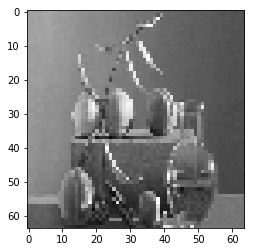

In [359]:
plt.imshow(smallImage,cmap='gray')

In [7]:
def source_points(shape):
    D1,D2 = shape
    sourceI, sourceJ= np.meshgrid(range(D1),range(D2))
    sourcePoints = np.array([sourceJ.flatten(),sourceI.flatten()]).T.astype('float64')
    return sourcePoints


#box = (left, upper, right, lower)
def get_box_center(boxtuple):
    left, upper, right, lower = boxtuple
    center_row = np.median([upper, lower])
    center_col = np.median([left, right])
    return np.array([center_row, center_col])

box = (0, 0, 10, 10)
print get_box_center(box)

def compose_and_iterate(sourcePoints, transformFuncList, activations=None, iterations=1):
    displacedPoints = copy(sourcePoints)
    ##apply transforms in series, noting activations, and assuming that xForm manages control point arithmetic
    if activations is None:
        activations = [1]*len(transformFuncList)
    for xForm,a in zip(transformFuncList,activations):
        if not a:
            xForm = lambda x: x
        displacedPoints = xForm(displacedPoints)
    ##reduce iterations
    iterations -= 1
    if iterations:
        return compose_and_iterate(displacedPoints, transformFuncList, activations, iterations=iterations)
    else:
        return displacedPoints
        

def local_affine_warp(sourcePoints, controlPoint, baseTransformMatrix, scaleFunction):
    
    r = pairwise_distances(sourcePoints, controlPoint)
    scalars = scaleFunction(r)  
    scaledXForms = scalars[:,:,np.newaxis]*baseTransformMatrix
    xForms = np.array(map(expm, scaledXForms))

    displacedPoints = np.sum((sourcePoints[:,:,np.newaxis]-controlPoint.T)*xForms,axis=2)+controlPoint

    return displacedPoints,xForms
    

#### Local affine warp in theano

In [ ]:
_X = T.matrix('sourcePoints') ##N x 2
_Y = T.row('controlPoint') ##1 x 2

##N x 1
_squared_euclidean_distances = (_X ** 2).sum(1).reshape((_X.shape[0], 1)) + (_Y ** 2).sum(1).reshape((1, _Y.shape[0])) - 2 * _X.dot(_Y.T)
f_euclidean = function([_X, _Y], T.sqrt(_squared_euclidean_distances))

##scalar
_sigma = T.scalar('sigma')

##N (?)
_scalars = (1./T.sqrt(2*np.pi*_sigma**2))*T.exp(-(_squared_euclidean_distances/(2*_sigma**2)))
f_scalars = function([_X,_Y,_sigma], _scalars)

In [255]:
##2 x 2
_xFormMatrix = T.matrix('baseTransformMatrix')

##N x 2 x 2
_scaledXForms = _scalars.dimshuffle((0,1,'x'))*_xFormMatrix
f_scaledXForms = function([_scalars,_xFormMatrix], _scaledXForms)

In [257]:
_xForms,updates = scan(T.slinalg.expm,sequences=_scaledXForms)

f_xForms = function([_X,_Y,_sigma,_xFormMatrix],outputs=_xForms)

In [260]:
_displacedPoints = T.sum((_X.dimshuffle((0,1,'x'))-_Y.T)*_xForms,axis=2)+_Y
f_displacedPoints = function([_X,_Y,_sigma, _xFormMatrix], outputs=_displacedPoints)

In [164]:
sp = np.array([10,10],ndmin=2).astype('float32')
cp = np.array([0,0],ndmin=2).astype('float32')
r = f_euclidean(sp,cp)
print r
print np.sqrt(200)
s = f_scalars(sp,cp,10)
print s
print norm.pdf(r,scale=10)




[[14.142136]]
14.142135623730951
[[0.01467627]]
[[0.01467627]]


In [267]:
sp = np.random.rand(10000,2).astype('float32')
s = f_scalars(sp,cp,10)*100
print s.shape


(10000, 1)


In [256]:
xfm = np.random.rand(2,2).astype('float32')*30
f_scaledXForms(s,xfm).shape

(10, 2, 2)

In [268]:
f_xForms(sp,cp,10,xfm).shape

(10000, 2, 2)

In [269]:
_dp = f_displacedPoints(sp,cp,10,xfm)

In [173]:
_dp.shape

(10, 2)

In [174]:
dp,xForms = local_affine_warp(sp,cp,xfm,scaleFunc)

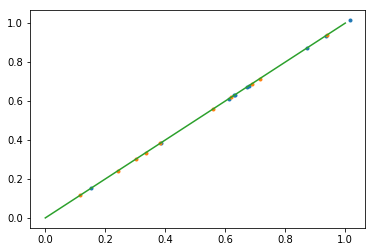

In [176]:
plt.plot(dp,_dp,'.')
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10))

#### Globally affine xforms around control points centered on objects

In [343]:
sourcePoints = source_points((D1,D2)).astype('float32')
xFormFuncList = []
activations = []
for objectLabel in np.unique(smallMap).tolist():
    scaleTuple = (1.001,1.001)#tuple(np.random.random(size=2)*1)

    xFormDict = {'scale':scaleTuple, 'rotation':0, 'shear':0., 'translation':None}
    xForm = AffineTransform(**xFormDict)
    box = object_box(smallMap,objectLabel)
    controlPoint = get_box_center(box)[np.newaxis,:].astype('float32')
    xFormFuncList += [lambda x,bc=controlPoint,xf=xForm.params: matrix_transform(x-bc,xf)+bc]
    activations += [1]

In [344]:
dp = compose_and_iterate(sourcePoints,xFormFuncList,activations=activations, iterations = 100)

warped = griddata(dp, np.array(smallMap).flatten(), sourcePoints, method = 'nearest')


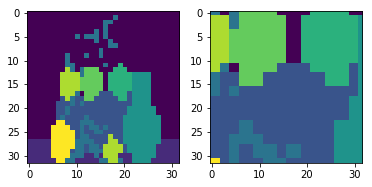

In [345]:
plt.subplot(1,2,1)
plt.imshow(np.array(smallMap))
plt.subplot(1,2,2)
plt.imshow(warped.reshape((D1,D2)))

#### Locally affine warps around control points centered on objects: numpy version

In [375]:
sourcePoints = source_points((D1,D2)).astype('float32')
xFormFuncList = []
activations = []
foo = []
sigma = 10
scaleFunc = lambda r: norm.pdf(r,scale=sigma)
for objectLabel in np.unique(smallMap).tolist():
    scaleTuple = tuple(np.random.randint(-1,1,size=2))
    rotation = 0 #np.random.random()*(np.pi/2.)-np.pi/4.
    xFormDict = {'scale':scaleTuple, 'rotation':rotation, 'shear':0., 'translation':None}
    xForm = AffineTransform(**xFormDict)
    baseTransformMatrix = xForm.params[:2,:2].astype('float32')
    box = object_box(smallMap,objectLabel)
    controlPoint = get_box_center(box)[np.newaxis,:].astype('float32')
    xFormFuncList += [lambda x, btm=baseTransformMatrix, cp=controlPoint: local_affine_warp(x,cp,btm, scaleFunc)[0]]
    print objectLabel
#     xFormFuncList += [lambda x, btm=baseTransformMatrix, cp=controlPoint: f_displacedPoints(x,cp,sigma,btm)]
    activations += [1]


0
28
59
87
117
145
173
199
227


In [376]:


start = time.time()
print("start compose_iterate")
dp = compose_and_iterate(sourcePoints,xFormFuncList,activations=activations, iterations =12)
end = time.time()
print "end compose_and_iterate: %f" %(end - start)


start compose_iterate
end compose_and_iterate: 103.669190


In [377]:
warped = griddata(dp, np.array(smallMap).flatten(), sourcePoints, method = 'nearest')

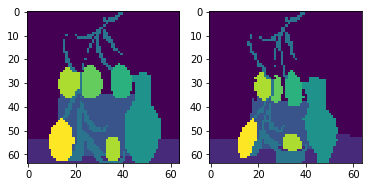

In [378]:
plt.subplot(1,2,1)
plt.imshow(np.array(smallMap))
plt.subplot(1,2,2)
plt.imshow(warped.reshape((D1,D2)))

#### Locally affine warps around control points centered on objects: Theano version

In [353]:
sourcePoints = source_points((D1,D2)).astype('float32')
xFormFuncList = []
activations = []
foo = []
sigma = 10
dp = copy(sourcePoints)
start = time.time()
print("start application loop")


for objectLabel in np.unique(smallMap).tolist():
    scaleTuple = tuple(np.random.randint(-5,5,size=2))

    xFormDict = {'scale':scaleTuple, 'rotation':0, 'shear':0., 'translation':None}
    xForm = AffineTransform(**xFormDict)
    baseTransformMatrix = xForm.params[:2,:2].astype('float32')
    box = object_box(smallMap,objectLabel)
    controlPoint = get_box_center(box)[np.newaxis,:].astype('float32')
#     xFormFuncList += [lambda x, btm=baseTransformMatrix, cp=controlPoint: local_affine_warp(x,cp,btm, scaleFunc)]
    print objectLabel
    dp = f_displacedPoints(dp,controlPoint,sigma,baseTransformMatrix)
    activations += [1]
    
end = time.time()
print "end compose_and_iterate: %f" %(end - start)

start application loop
0
28
59
87
117
145
173
199
227
end compose_and_iterate: 3.167833


In [354]:
warped = griddata(dp, np.array(smallMap).flatten(), sourcePoints, method = 'nearest')

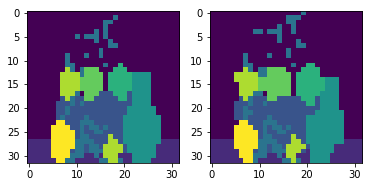

In [355]:
plt.subplot(1,2,1)
plt.imshow(np.array(smallMap))
plt.subplot(1,2,2)
plt.imshow(warped.reshape((D1,D2)))

Seems that locally affine warp is slow because of applying expm to all of the source points for each control point and xform. This isn't any faster in theano, so there's no speed up. In fact, theano is slower. Probably because of shuttling data back and forth from gpu/cpu when there's really no need in this case.

### ============================TOSSED=============================

### =============================================================

In [ ]:
idx = 376
row,col = np.unravel_index(idx,(D1,D2))
print '(row,col): (%d, %d)' %(row,col)
print '(s_row, s_col): (%d,%d)' %(sourcePoints[idx][0], sourcePoints[idx][1])

In [ ]:
##this was mostly just for visualizing that coordinate transforms are correct
def mask_box(sourcePoints, boxtuple, fill=0):
    left, upper, right, lower = boxtuple
    boxMask = copy(sourcePoints)
    boxMask[np.where((sourcePoints[:,1] <= left) + 
                             (sourcePoints[:,1] >= right) +
                             (sourcePoints[:,0] >= lower) +
                             (sourcePoints[:,0] <= upper))] = fill
    return boxMask
    
    

In [ ]:
def row_col_to_x_y(row_col_coords, row_col_origin=None):
    '''
    row_col_to_x_y(row_col_coords)
    row_col_coords ~ N x 2 array
    row_col_origin ~ np array with shape (2,) -- no singleton dimension so we can broadcast without headaches!
    returns N x 2 array in cartesian (x,y) coordinates with row_col_origin
    at the center of (x,y) plane. if row_col_origin = None, set to median
    of row_col_coords
    
    example: if row_col_coords is a sourcePoint array (so that values equal subscripts)
    and row_col_origin is not supplied, we will get (x,y) coordinates for each pixel (row,col)
    coordinate, and the center of the image will be at the origin of the (x,y) plane.
    if row_col_coords is set to (0,0), the upper left cornder of the image will be at the center of
    the (x,y) plane
    '''    
    if row_col_origin is None:
        left = row_col_coords[:,1].min()
        upper = row_col_coords[:,0].min()
        right = row_col_coords[:,1].max()
        lower = row_col_coords[:,0].max()
        row_col_origin = get_box_center((left,upper,right,lower))
    x_y_coords = np.roll(row_col_coords-row_col_origin,1,1)
    return x_y_coords,row_col_origin

def x_y_to_row_col(x_y_coords, x_y_origin=np.array([0,0])):
    row_col_coords = np.roll(x_y_coords-x_y_origin, 1,1)
    return row_col_coords

In [ ]:
sourcePoints_x_y = row_col_to_x_y(sourcePoints)
##plot sourcepoints as an image in row,col space
plt.subplot(1,3,1)
plt.imshow(sourcePoints[:,0].reshape((D1,D2)))
plt.subplot(1,3,2)
plt.imshow(sourcePoints[:,1].reshape((D1,D2)))

##plot (x,y) version of sourcePoints as point plot in (x,y) plane
plt.subplot(1,3,3)
plt.plot(sourcePoints_x_y[:,0], sourcePoints_x_y[:,1], 'k.')
plt.axis('equal')

In [ ]:
box = (10, 38, 53, 42)
box_center = get_box_center(box)
print box_center
boxMask = mask_box(sourcePoints,box)
boxMask_x_y = row_col_to_x_y(boxMask,box_center)

In [ ]:
##plot box as an image in row,col space
plt.subplot(1,3,1)
plt.imshow(boxMask[:,0].reshape((D1,D2)))
plt.subplot(1,3,2)
plt.imshow(boxMask[:,1].reshape((D1,D2)))

##plot (x,y) version of box as point plot in (x,y) plane
plt.subplot(1,3,3)
plt.plot(boxMask_x_y[:,0], boxMask_x_y[:,1], 'k.')
plt.axis('equal')

In [ ]:
##construct a local affine transform and apply it in the nbd of that box
xFormDict = {'scale':(2.5,2.5), 'rotation':0., 'shear':0., 'translation':(0,0)}
xForm = AffineTransform(**xFormDict)

In [ ]:
#select an object from the object map and create a box around it
print 'choose from these labels: '+str(np.unique(smallMap).tolist())
objectLabel = 117
box = object_box(smallMap,objectLabel)
boxCenter = get_box_center(box)
print 'box:'+str(box)
boxMask = mask_box(sourcePoints,box,fill=np.nan)
boxMask_x_y = row_col_to_x_y(boxMask,box_center)
plt.subplot(1,3,1)
plt.imshow(np.array(smallMap))
plt.subplot(1,3,2)
plt.imshow(boxMask[:,0].reshape((D1,D2)))
plt.subplot(1,3,3)
plt.plot(boxMask_x_y[:,0], boxMask_x_y[:,1], 'k.')
plt.axis('equal')

In [ ]:
##apply transform to points within box only
localDisplacedPoints_x_y = matrix_transform(boxMask_x_y,xForm.params)
localDisplacementMap_row_col = np.nan_to_num(x_y_to_row_col(localDisplacedPoints_x_y-boxMask_x_y))
localDisplacedPoints_row_col = sourcePoints+localDisplacementMap_row_col
warpedMap = griddata(localDisplacedPoints_row_col, np.array(smallMap).flatten(), sourcePoints, method='nearest')

In [ ]:
plt.subplot(1,2,1)
plt.imshow(np.array(smallMap))
plt.subplot(1,2,2)
plt.imshow(warpedMap.reshape((D1,D2)))

In [ ]:
##apply to transform about box_center to whole image
sourcePoints_x_y = row_col_to_x_y(sourcePoints,row_col_origin=boxCenter)
displacedPoints_x_y = matrix_transform(sourcePoints_x_y,xForm.params)
displacementMap_row_col = np.nan_to_num(x_y_to_row_col(displacedPoints_x_y-sourcePoints_x_y))
displacedPoints_row_col = sourcePoints+displacementMap_row_col
warpedMap = griddata(displacedPoints_row_col, np.array(smallMap).flatten(), sourcePoints, method='nearest')

In [ ]:
plt.subplot(1,2,1)
plt.imshow(np.array(smallMap))
plt.subplot(1,2,2)
plt.imshow(warpedMap.reshape((D1,D2)))

In [ ]:
##create a composite transform by adding another scale around a different point and apply it
##construct a local affine transform and apply it in the nbd of that box
newXFormDict = {'scale':(.1, .1), 'rotation':np.pi/15., 'shear':0., 'translation':(0,0)}
newXForm = AffineTransform(**newXFormDict)
newBox = (10, 40, 20, 60)
newBoxCenter = get_box_center(newBox)
newSourcePoints_x_y = row_col_to_x_y(sourcePoints,row_col_origin=newBoxCenter)
newDisplacedPoints_x_y = matrix_transform(newSourcePoints_x_y,newXForm.params)
newDisplacementMap_row_col = np.nan_to_num(x_y_to_row_col(newDisplacedPoints_x_y-newSourcePoints_x_y))
newDisplacedPoints_row_col = sourcePoints+newDisplacementMap_row_col
newWarpedMap = griddata(newDisplacedPoints_row_col, np.array(smallMap).flatten(), sourcePoints, method='nearest')

In [ ]:
plt.subplot(1,2,1)
plt.imshow(np.array(smallMap))
plt.subplot(1,2,2)
plt.imshow(newWarpedMap.reshape((D1,D2)))

In [ ]:
compositeDisplacementMap_row_col = newDisplacementMap_row_col+displacementMap_row_col
compositeDisplacedPoints_row_col = sourcePoints+compositeDisplacementMap_row_col
compositeWarpedMap = griddata(compositeDisplacedPoints_row_col, np.array(smallMap).flatten(), sourcePoints, method = 'nearest')

In [ ]:
plt.subplot(1,2,1)
plt.imshow(np.array(smallMap))
plt.subplot(1,2,2)
plt.imshow(compositeWarpedMap.reshape((D1,D2)))

In [ ]:
##now iterate, applying the displacement map once again
compositeDisplacedPoints_row_col += compositeDisplacementMap_row_col
compositeWarpedMap = griddata(compositeDisplacedPoints_row_col, np.array(smallMap).flatten(), sourcePoints, method = 'nearest')


In [ ]:
plt.subplot(1,2,1)
plt.imshow(np.array(smallMap))
plt.subplot(1,2,2)
plt.imshow(compositeWarpedMap.reshape((D1,D2)))

In [ ]:
##may be easier to just compose affine transforms instead of adding displacement maps
# xFormDict1 = {'scale':(.5,.5), 'rotation':0, 'shear':0., 'translation':(0,0)}
# xForm1 = AffineTransform(**xFormDict1)
xFormDict1 = {'scale':(.5,.5), 'rotation':np.pi/26., 'translation':(1,0)}
xForm1 = SimilarityTransform(**xFormDict1)
objectLabel = 145
box1 = object_box(smallMap,objectLabel)
boxCenter1 = get_box_center(box1)
sourcePoints_x_y_1,_ = row_col_to_x_y(sourcePoints,row_col_origin=boxCenter1)
displacedPoints_x_y_1 = matrix_transform(sourcePoints_x_y_1,xForm1.params)
displacedPoints_row_col_1 = x_y_to_row_col(displacedPoints_x_y_1)+boxCenter1
warp1 = griddata(displacedPoints_row_col_1, np.array(smallMap).flatten(), sourcePoints, method = 'nearest')

xFormDict2 = {'scale':(1,1), 'rotation':0, 'shear':0., 'translation':(20,0)}
xForm2 = AffineTransform(**xFormDict2)
objectLabel = 117
box2 = object_box(smallMap,objectLabel)
boxCenter2 = get_box_center(box2)
sourcePoints_x_y_2,_ = row_col_to_x_y(displacedPoints_row_col_1,row_col_origin=boxCenter2)
displacedPoints_x_y_2 = matrix_transform(sourcePoints_x_y_2,xForm2.params)
displacedPoints_row_col_2 = x_y_to_row_col(displacedPoints_x_y_2)+boxCenter2
warp2 = griddata(displacedPoints_row_col_2, np.array(smallMap).flatten(), sourcePoints, method = 'nearest')


In [ ]:
##nice. much easier
plt.subplot(1,3,1)
plt.imshow(np.array(smallMap))
plt.subplot(1,3,2)
plt.imshow(warp1.reshape((D1,D2)))
plt.subplot(1,3,3)
plt.imshow(warp2.reshape((D1,D2)))


In [ ]:
##can't we just stay in row,col space?
sourcePoints = source_points((D1,D2))
xFormDict = {'scale':(.5,.5), 'rotation':0, 'shear':0., 'translation':(0,0)}
xForm = AffineTransform(**xFormDict)
boxCenter2 = np.array([60,55])
print boxCenter2
dp = matrix_transform(sourcePoints-boxCenter2,xForm.params,)+boxCenter2
dp0 = matrix_transform(boxCenter2-boxCenter2,xForm.params,)+boxCenter2
warped = griddata(dp, np.array(smallMap).flatten(), sourcePoints, method = 'nearest')
plt.subplot(1,2,1)
plt.imshow(np.array(smallMap))
plt.plot(boxCenter2[1],boxCenter2[0],'r*')
plt.subplot(1,2,2)
plt.imshow(warped.reshape((D1,D2)))
plt.plot(dp0[:,1],dp0[:,0],'r*')

In [ ]:
dp0

In [ ]:
pt = np.array([64,64])
print xForm2.params[:2,:2].dot(np.array([64,64]))
print matrix_transform(pt,xForm2.params)

In [ ]:
base = np.random.rand(2,2)
controlPoints = np.array([0,0])[np.newaxis,:]
r = pairwise_distances(sourcePoints, controlPoints)

In [ ]:
scalars = norm.pdf(r)  
scalars.shape
print sourcePoints.shape

In [ ]:
scaledXForms = scalars[:,:,np.newaxis]*base
xForms = np.array(map(expm, scaledXForms))
print xForms.shape

In [ ]:
print np.squeeze(controlPoints).shape
print base.shape

In [ ]:
(sourcePoints[:,:,np.newaxis]-controlPoints.T).shape

In [ ]:
np.sum((sourcePoints[:,:,np.newaxis]-controlPoints.T)*xForms,axis=2).shape

In [ ]:
xFormDict = {'scale':(30.5,30.5), 'rotation':np.pi/2.0, 'shear':0., 'translation':(0,0)}
xForm = AffineTransform(**xFormDict)
btm = xForm.params[:2,:2]
objectLabel = 117
box1 = object_box(smallMap,objectLabel)
boxCenter1 = get_box_center(box1)[np.newaxis,:]

scaleFunc = lambda r: norm.pdf(r,scale=10.)

# scaleFunc = lambda r: r*0+1

In [ ]:
D1,D2 = np.array(smallMap).shape
sourcePoints = source_points((D1,D2))
dp = local_affine_warp(sourcePoints, boxCenter1, btm, scaleFunc)
warped = griddata(dp, np.array(smallMap).flatten(), sourcePoints, method = 'nearest')
plt.subplot(1,2,1)
plt.imshow(np.array(smallMap))
plt.subplot(1,2,2)
plt.imshow(warped.reshape((D1,D2)))

In [ ]:
smallMap

### How to build and an apply a complex piecewise affine distortion to an image

-  create a set of source gridpoints (extract them from an image)
-  construct distortions using AffineTransform
-  use "matrix_transform" to apply the affine transform to a subset of the source gridpoints (a box)
-  iteratively displace t times
-  generate displacement map for the local transform
-  if many local transforms, sum the displacement maps
-  add the displacement map to the source gridpoints to get displaced gridpoints
-  pass the displaced points, the image, and the source gridpoints to griddata to get the warped image

In [ ]:
##FIX API, FIX CENTERING ISSUES
def source_points_from_image(image,center=False):
    D1,D2 = image.shape
    sourceI, sourceJ= np.meshgrid(range(D1),range(D2))
    sourcePoints = np.array([sourceI.flatten(),sourceJ.flatten()]).T.astype('float64')
    centerPoint = center_of_mass(np.ones((D1,D2)))
    if center:
        sourcePoints = sourcePoints-centerPoint
    return sourcePoints, centerPoint

def displacement_map(sourcePoints, xForm, box=None):
    if box is not None:
        left,upper,right,lower = box
        centerPoint = np.array([np.median([right,left]), np.median([upper,lower])])
        sourcePoints = sourcePoints-centerPoint
    displacedPoints = matrix_transform(sourcePoints,xForm.params)
    displacementMap = displacedPoints - sourcePoints
    sourcePoints = sourcePoints+centerPoint
    if box is not None:
        displacementMap[np.where((sourcePoints[:,0] <= left) + 
                                 (sourcePoints[:,0] >= right) +
                                 (sourcePoints[:,1] <= lower) +
                                 (sourcePoints[:,1] >= upper))] = 0
        
    return displacementMap

def cart2img(dmap, D1,D2):
    flipped = np.empty(dmap.shape)
    flipped[:,0] = np.flip(dmap[:,0].reshape((D1,D2)), axis=0).flatten()
    flipped[:,1] = np.flip(dmap[:,1].reshape((D1,D2)), axis=0).flatten()
    return flipped

def apply_displacement_map(sourcePoints, displacementMap, t=1):
    if t:
        t -= 1
        return apply_displacement_map(sourcePoints+displacementMap, displacementMap, t)
    else:
        return sourcePoints
    

In [ ]:
left,upper,right,lower = (-63.5, 39.5, 64.5, 64.5)
plt.subplot(1,2,1)
foo = copy(sourcePoints)
foo[np.where((sourcePoints[:,0]<=left) + 
              (sourcePoints[:,0] >= right) +
              (sourcePoints[:,1] <=upper) +
              (sourcePoints[:,1] >= lower))] = 0
plt.plot(sourcePoints[:,0],sourcePoints[:,1], 'k.')
plt.plot(foo[:,0],foo[:,1], 'r*')
plt.axis('equal')
baz = np.ones(sourcePoints.shape)
baz[np.where((sourcePoints[:,0]<=left) + 
              (sourcePoints[:,0] >= right) +
              (sourcePoints[:,1] <=upper) +
              (sourcePoints[:,1] >= lower))] = 0
plt.subplot(1,2,2)
blarg = np.flip(baz[:,0].reshape((D1,D2)), axis=0).flatten()
plt.imshow(blarg.reshape((D1,D2)))

In [ ]:
def center_box(boxtuple, origin):
    left,upper,right,lower = boxtuple
    left -= origin[0]
    right -= origin[0]
    upper -= origin[1]
    lower -= origin[1]
    return (left,upper,right,lower)

In [ ]:
xFormDict = {'scale':(10.,10.), 'rotation':0., 'shear':0., 'translation':(0,0)}
xForm = AffineTransform(**xFormDict)

In [ ]:
np.unique(targetObjectMap)

In [ ]:
objectLabel = 123
objectMask = np.flip(mask_quantize(targetObjectMap,objectLabel).resize((D1,D2)),axis=0)
objectMask=fromarray(objectMask)
objectMask

In [ ]:
sourcePoints,cp = source_points_from_image(smallImage,center=True)

In [ ]:
maskBox = object_box(objectMask,255)
maskBox = center_box(maskBox,cp)
maskBox

In [ ]:
dmap = displacement_map(sourcePoints, xForm, box=maskBox)#(-1, -1, 1, -4))
displacedPoints = apply_displacement_map(sourcePoints, dmap, t=1)
dmap = cart2img(dmap,D1,D2)

In [ ]:
plt.plot(sourcePoints[:,0],sourcePoints[:,1], 'k.')
plt.plot(dmap[:,0],dmap[:,1], 'r*')
plt.axis('equal')

In [ ]:
plt.subplot(1,2,1)
plt.imshow(smallImage, cmap='gray')
plt.subplot(1,2,2)
warpedImg = griddata(displacedPoints,smallImage.flatten(),sourcePoints, method='nearest')
plt.imshow(warpedImg.reshape(D1,D2), cmap='gray')

### Random sampling of distortions
-  construct a bank of affine transforms to apply at each location and scale
-  randomly sample activations from a "multinoulli" (product of Bernoullis each with same parameter)
-  randmoly sample iterations from a Poisson
-  apply as described above

In [ ]:
def zoom_or_pan(sourcePoints,centerPoint,direction):
    '''
    zoom_or_pan(sourcePoints,centerPoint,direction)
    applies a panning or zooming coordinate transform to sourcePoints around
    the centerPoint.
    Inputs:
        sourcePoints ~ N x 2 array of 2D points
        centerPoint ~ 1 x 2 array giving center point for effect
        direction ~ < 0 = zoom in, > 0 = pan out. absolute determines size of effect
    Returns:
        displacedPoints ~ N x 2 array of transformed points
    '''
    sourcePoints = sourcePoints-np.array(centerPoint).reshape((1,2))
    angles = np.angle(np.apply_along_axis(lambda args: [complex(*args)], 1, sourcePoints))    
    displacementVectors = direction*np.array([np.cos(angles),np.sin(angles)]).T
    displacedPoints = sourcePoints+displacementVectors
    return np.squeeze(displacedPoints), np.squeeze(displacementVectors)